In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

from svd import ApproxSVD

In [12]:
def load_mnist_subset(n_samples=2000):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32).to_numpy() / 255.0
    X = X.T[:, :n_samples]  # (784, n_samples)
    
    return X

In [13]:
def show_reconstruction(X_orig, X_recon, num_images=10):
    plt.figure(figsize=(num_images, 2))
    
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_orig[:, i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(X_recon[:, i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

In [14]:
def explained_variance_ratio(X, X_reconstructed):
    error = np.linalg.norm(X - X_reconstructed, 'fro')**2
    total = np.linalg.norm(X, 'fro')**2
    
    return 1 - error / total

In [15]:
def run_approx_svd_experiment(input_data, p=50, g=200):
    X = input_data

    approx_svd = ApproxSVD(g, p, 'fro', True, 1)
    traces, U, X_approx = approx_svd.fit(X)

    X_reduced = U.T[:p, :] @ X              # (p x d) @ (d x n) = (p x n)
    X_reconstructed = U[:, :p] @ X_reduced  # (d x p) @ (p x n) = (d x n)

    error = np.linalg.norm(X - X_reconstructed, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    explained_variance_ratio = 1 - (error / total)
    print(f"Explained Variance: {explained_variance_ratio * 100:.2f}%")

    show_reconstruction(X, X_reconstructed)

In [16]:
mnist_np = load_mnist_subset(n_samples=2000)

DEBUG - Time: 3.547 seconds for initial scores
100%|██████████| 20/20 [00:00<00:00, 55.41it/s]
DEBUG - Time: 3.913 seconds for total time


Explained Variance: 9.34%


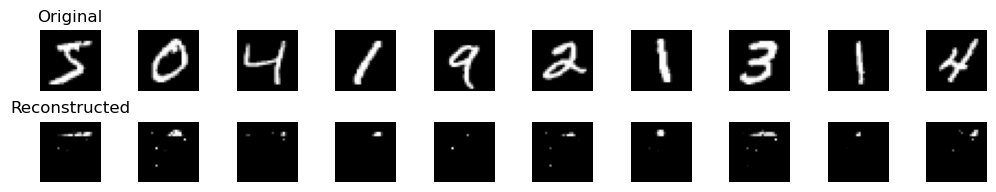

In [17]:
run_approx_svd_experiment(mnist_np, p=200, g=20)

DEBUG - Time: 3.593 seconds for initial scores
100%|██████████| 200/200 [00:03<00:00, 51.19it/s]
DEBUG - Time: 7.513 seconds for total time


Explained Variance: 12.63%


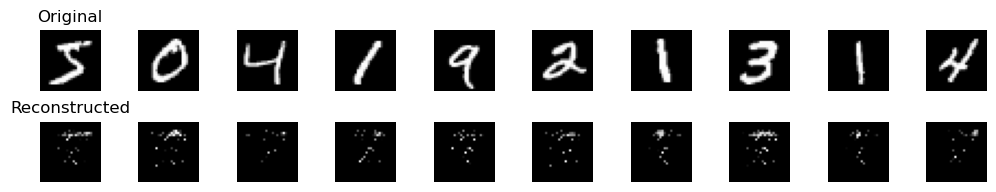

In [18]:
run_approx_svd_experiment(mnist_np, p=200, g=200)

In [ ]:
# this does 45% with formula
run_approx_svd_experiment(mnist_np, p=200, g=2000)

In [ ]:
run_approx_svd_experiment(mnist_np, p=200, g=20000)

In [ ]:
run_approx_svd_experiment(mnist_np, p=50, g=20000)